# Training with a custom implementation of ResNet

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from pathlib import Path
import numpy as np 
import pandas as pd
import pickle
import skimage as io

import matplotlib.pyplot as plt

# tqdm is a library that enables you to visualize the progress of a for loop by displaying a configurable progress bar
from tqdm.notebook import tqdm
tqdm().pandas();

0it [00:00, ?it/s]

## 1. Loading data

In [2]:
sample_df = pd.read_pickle(r"./data/images.pkl")

## 2. Split into training and testing

In [3]:
images_arrays = sample_df.img_array.to_numpy()
X = np.zeros(shape = (150000,3,50,50), dtype = np.uint8) # uint8 = unsigned integer from 0 to 255
y = sample_df.target.to_numpy()

for index in tqdm(range(150000)):
    X[index] = images_arrays[index].reshape((3,50,50))

  0%|          | 0/150000 [00:00<?, ?it/s]

In [4]:
#shuffle data and split data to generate validation data
shuffler = np.random.RandomState(seed=42).permutation(150000)
X_shf = X[shuffler]
y_shf = y[shuffler]


# split 80 / 20
X_train=X_shf[0:120000]
y_train=y_shf[0:120000]
X_test=X_shf[120000:150000]
y_test=y_shf[120000:150000]

In [5]:
#save for future use without having to reload from the images folders
np.save('data/X_test.npy', X_test)
np.save('data/y_test.npy', y_test)
np.save('data/X_train.npy', X_train)
np.save('data/y_train.npy', y_train)

In [6]:
print('script running in '+os.path.abspath("."))
X_test = np.load('./data/X_test.npy')
y_test = np.load('./data/y_test.npy')
X_train = np.load('./data/X_train.npy')
y_train = np.load('./data/y_train.npy')

script running in /home/ecbm4040/BreastHistopathologyWithPytorch


## 3. Set up for training

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report

import torchvision
import torchvision.transforms as transforms

from barbar import Bar

from models.resnet import ResNet18, ResNet34, ResNet50

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
## train data
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data, transform = None):
        self.X_data = X_data
        self.y_data = y_data
        # data augmentation
        self.transform = transform
        
    def __getitem__(self, index):

        if self.transform:
            X_data_ = self.transform(self.X_data[index])
        else:
            X_data_ = self.X_data[index]

        return X_data_, self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


## test data    
class TestData(Dataset):
    
    def __init__(self, X_data, y_data, transform = None):
        self.X_data = X_data
        self.y_data = y_data
        # data augmentation
        self.transform = transform
        
    def __getitem__(self, index):

        if self.transform:
            X_data_ = self.transform(self.X_data[index])
        else:
            X_data_ = self.X_data[index]

        return X_data_, self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
# setting up train and test sets
train_data = TrainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train), transform = None)
test_data = TestData(torch.FloatTensor(X_test), torch.FloatTensor(y_test), transform = None)

In [10]:
# tranformations for data augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(50, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [11]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [12]:
# Training
def train(model, epoch):
    print('\nEpoch: %d' % epoch)
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(Bar(train_loader)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, targets.unsqueeze(1))
        acc = binary_acc(outputs, targets.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    print(f'Epoch {epoch+0:03}: | Training loss: {epoch_loss/len(train_loader):.5f} | Training acc: {epoch_acc/len(train_loader):.3f}')
    return epoch_loss/len(train_loader), epoch_acc/len(train_loader)

In [13]:
def test(model, epoch, model_name = 'ResNet18'):
    global best_acc
    model.eval()
    test_loss = 0
    test_acc = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(Bar(test_loader)):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))
            acc = binary_acc(outputs, targets.unsqueeze(1))

            test_loss += loss.item()
            test_acc += acc.item()

        print(f'Epoch {epoch+0:03}: | Testing loss: {test_loss/len(test_loader):.5f} | Testing acc: {test_acc/len(test_loader):.3f}')

    # Save checkpoint.
    acc = test_acc/len(test_loader)
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/' + model_name + '.pth')
        best_acc = acc
    
    return test_loss/len(test_loader), test_acc/len(test_loader)

In [14]:
def plot_performance(model_name, training_loss, training_acc, testing_loss, testing_acc):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

    # subplot for losses
    ax1.grid()
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.plot(training_loss, color = 'blue', label = "training loss")
    ax1.plot(testing_loss, color = 'green', label = "testing loss")
    ax1.legend()

    # subplot for losses
    ax2.grid()
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('accuracy')
    ax2.plot(training_acc, color = 'blue', label = "training accuracy")
    ax2.plot(testing_acc, color = 'green', label = "testing accuracy")
    ax2.legend()

    plt.subplots_adjust(wspace=0.5)
    plt.suptitle(model_name)
    plt.savefig('figures/' + model_name + '.png')
    plt.show()

## 4. ResNet18

In [24]:
print('Building ResNet18..')
model = ResNet18(num_classes=1)
model.to(device)

Building ResNet18..


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (stage2): Sequential(
    (0): ConvBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential()
    )
    (1): ConvBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [25]:
# training parameters
BATCH_SIZE = 128
LEARNING_RATE = 0.01
EPOCHS = 15

# instantiate data loaders
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=100)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = "min", patience = 1, verbose = True)

In [26]:
resume = False
model_name = 'ResNet18'

In [27]:
train_loss, test_loss = [], []
train_acc, test_acc = [], []
best_acc = 0

for epoch in range(EPOCHS):
    trnl, trnacc = train(model, epoch)
    tstl, tstacc = test(model, epoch, 'ResNet18')
    train_loss.append(trnl)
    train_acc.append(trnacc)
    test_loss.append(tstl)
    test_acc.append(tstacc)
    scheduler.step(tstl)


Epoch: 0
120000/120000: [===============================>] - ETA 0.1ss
Epoch 000: | Training loss: 0.44463 | Training acc: 80.763
30000/30000: [===============================>] - ETA 0.0s
Epoch 000: | Testing loss: 0.47955 | Testing acc: 79.427
Saving..

Epoch: 1
120000/120000: [===============================>] - ETA 0.1ss
Epoch 001: | Training loss: 0.40406 | Training acc: 82.570
30000/30000: [===============================>] - ETA 0.0s
Epoch 001: | Testing loss: 0.45628 | Testing acc: 80.920
Saving..

Epoch: 2
120000/120000: [===============================>] - ETA 0.1ss
Epoch 002: | Training loss: 0.39002 | Training acc: 83.088
30000/30000: [===============================>] - ETA 0.0s
Epoch 002: | Testing loss: 0.48727 | Testing acc: 77.407

Epoch: 3
120000/120000: [===============================>] - ETA 0.1ss
Epoch 003: | Training loss: 0.38078 | Training acc: 83.570
30000/30000: [===============================>] - ETA 0.0s
Epoch 003: | Testing loss: 0.51430 | Testing acc: 7

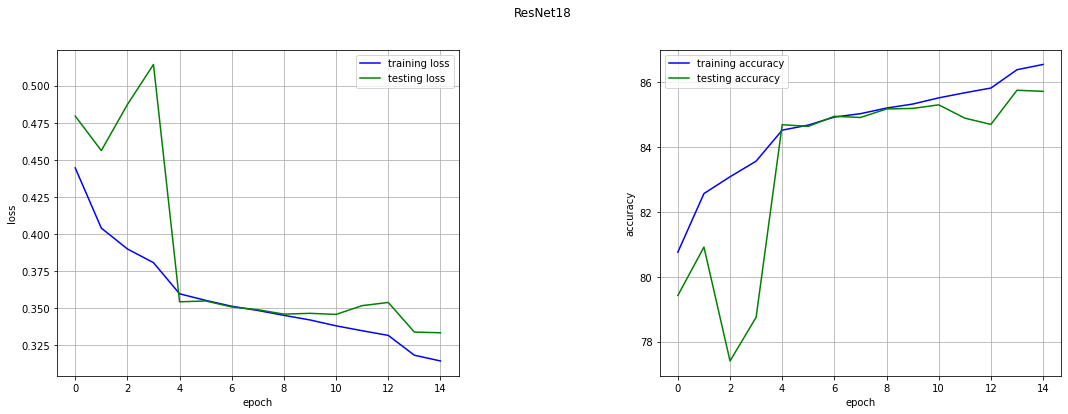

In [28]:
plot_performance('ResNet18', train_loss, train_acc, test_loss, test_acc)

In [30]:
print("Best accuracy was", round(best_acc, 2), "%.")

Best accuracy was 85.76 %.


## 5. ResNet34

In [31]:
print('Building ResNet34..')
model = ResNet34(num_classes=1)
model.to(device)

Building ResNet34..


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (stage2): Sequential(
    (0): ConvBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential()
    )
    (1): ConvBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [32]:
# training parameters
BATCH_SIZE = 128
LEARNING_RATE = 0.01
EPOCHS = 15

# instantiate data loaders
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=100)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = "min", patience = 1, verbose = True)

In [33]:
resume = False
model_name = 'ResNet34'

In [34]:
train_loss, test_loss = [], []
train_acc, test_acc = [], []
best_acc = 0

for epoch in range(EPOCHS):
    trnl, trnacc = train(model, epoch)
    tstl, tstacc = test(model, epoch, 'ResNet34')
    train_loss.append(trnl)
    train_acc.append(trnacc)
    test_loss.append(tstl)
    test_acc.append(tstacc)
    scheduler.step(tstl)


Epoch: 0
120000/120000: [===============================>] - ETA 0.1sss
Epoch 000: | Training loss: 0.43752 | Training acc: 80.915
30000/30000: [===============================>] - ETA 0.0s
Epoch 000: | Testing loss: 0.41383 | Testing acc: 82.600
Saving..

Epoch: 1
120000/120000: [===============================>] - ETA 0.1sss
Epoch 001: | Training loss: 0.40227 | Training acc: 82.590
30000/30000: [===============================>] - ETA 0.0s
Epoch 001: | Testing loss: 0.53309 | Testing acc: 76.180

Epoch: 2
120000/120000: [===============================>] - ETA 0.1sss
Epoch 002: | Training loss: 0.39282 | Training acc: 82.916
30000/30000: [===============================>] - ETA 0.0s
Epoch 002: | Testing loss: 0.55902 | Testing acc: 73.413
Epoch     3: reducing learning rate of group 0 to 1.0000e-03.

Epoch: 3
120000/120000: [===============================>] - ETA 0.1sss
Epoch 003: | Training loss: 0.37508 | Training acc: 83.775
30000/30000: [===============================>] - ETA

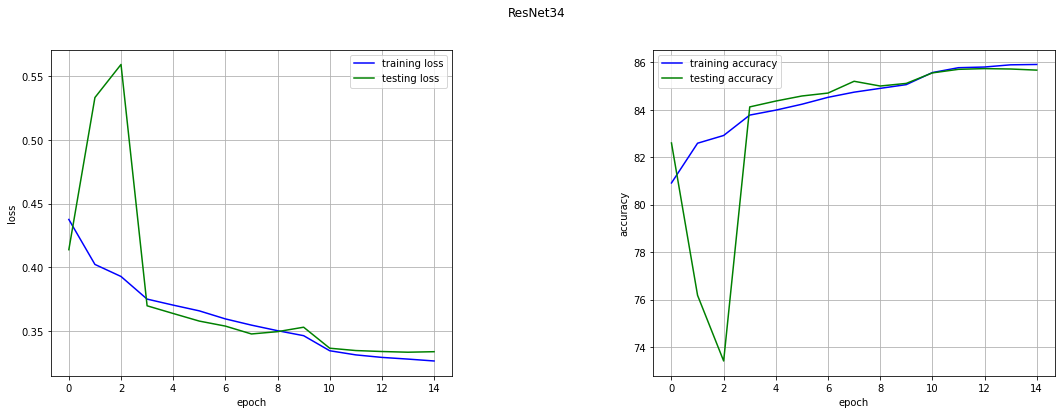

In [35]:
plot_performance('ResNet34', train_loss, train_acc, test_loss, test_acc)

In [36]:
print("Best accuracy was", round(best_acc, 2), "%.")

Best accuracy was 85.73 %.


## 6. ResNet50

In [37]:
print('Building ResNet50..')
model = ResNet50(num_classes=1)
model.to(device)

Building ResNet50..


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (stage2): Sequential(
    (0): ConvBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ConvBlock(
      (conv1)

In [38]:
# training parameters
BATCH_SIZE = 128
LEARNING_RATE = 0.01
EPOCHS = 15

# instantiate data loaders
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=100)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = "min", patience = 1, verbose = True)

In [39]:
resume = False
model_name = 'ResNet50'

In [40]:
train_loss, test_loss = [], []
train_acc, test_acc = [], []
best_acc = 0

for epoch in range(EPOCHS):
    trnl, trnacc = train(model, epoch)
    tstl, tstacc = test(model, epoch, 'ResNet50')
    train_loss.append(trnl)
    train_acc.append(trnacc)
    test_loss.append(tstl)
    test_acc.append(tstacc)
    scheduler.step(tstl)


Epoch: 0
120000/120000: [===============================>] - ETA 0.2sss
Epoch 000: | Training loss: 0.44602 | Training acc: 80.502
30000/30000: [===============================>] - ETA 0.1ss
Epoch 000: | Testing loss: 0.46703 | Testing acc: 79.630
Saving..

Epoch: 1
120000/120000: [===============================>] - ETA 0.2sss
Epoch 001: | Training loss: 0.40541 | Training acc: 82.437
30000/30000: [===============================>] - ETA 0.1ss
Epoch 001: | Testing loss: 0.46866 | Testing acc: 78.020

Epoch: 2
120000/120000: [===============================>] - ETA 0.2sss
Epoch 002: | Training loss: 0.39333 | Training acc: 82.972
30000/30000: [===============================>] - ETA 0.1ss
Epoch 002: | Testing loss: 0.71565 | Testing acc: 74.793
Epoch     3: reducing learning rate of group 0 to 1.0000e-03.

Epoch: 3
120000/120000: [===============================>] - ETA 0.2sss
Epoch 003: | Training loss: 0.37299 | Training acc: 83.930
30000/30000: [===============================>] - 

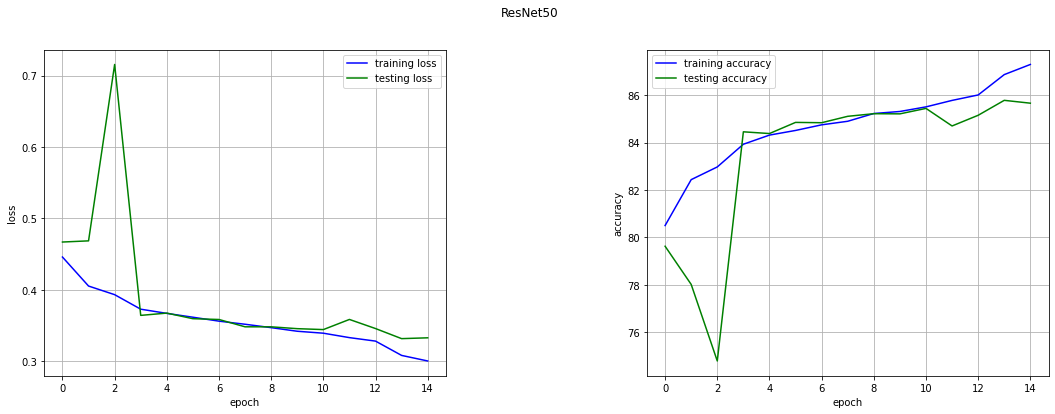

In [41]:
plot_performance('ResNet50', train_loss, train_acc, test_loss, test_acc)

In [42]:
print("Best accuracy was", round(best_acc, 2), "%.")

Best accuracy was 85.78 %.
